In [102]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from rcgp.rcgp import GPRegressor, RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,          # Use LaTeX to render text
    "font.family": "serif",       # Use serif fonts (optional, but often nicer)
    "text.latex.preamble": r"\usepackage{amsmath}"  # Add extra LaTeX packages if needed
})

plt.rcParams.update({
    'font.size': 24,         # larger font size
    'axes.labelsize': 24,    # axis labels
    'xtick.labelsize': 24,   # x tick labels
    'ytick.labelsize': 24,   # y tick labels
    'legend.fontsize': 16,
    'lines.linewidth': 4,    # default line width
    'lines.markersize': 5   # default marker size
})

## Simulation

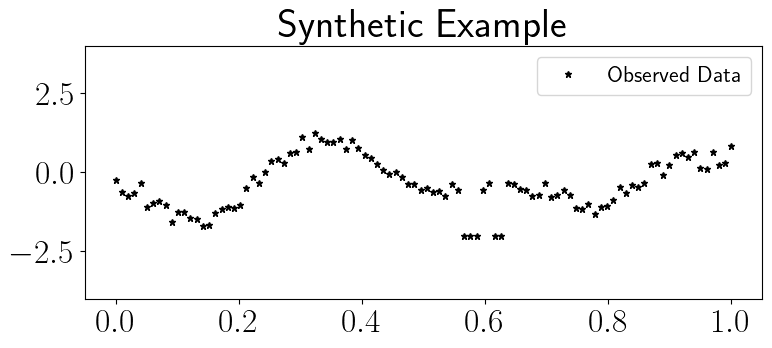

In [4]:
np.random.seed(42)

# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
noise_variance = 0.04

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=variance)

x_train = np.linspace(0, 1, 100).reshape(-1, 1)
K_train = rbf_kernel(x_train, x_train)
K_train_noise = K_train + noise_variance * np.eye(len(x_train))
y_train = np.random.multivariate_normal(mean_func(x_train).flatten(), K_train_noise).reshape(-1, 1)

# Add outliers
outlier_range = np.where((x_train >= 0.55) & (x_train <= 0.63))[0]
outlier_indices = np.random.choice(outlier_range, 5, replace=False)
y_train[outlier_indices] = -2

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.plot(x_train, y_train, 'k*', label='Observed Data')
axs.set_title("Synthetic Example")
axs.set_ylim([-4, 4])
axs.legend()

plt.tight_layout()
plt.show()

## Standard GP

In [51]:
# Instantiate and train
gp = GPRegressor(mean = 0, length_scale=length_scale, rbf_variance = variance, noise = noise_variance)
gp.fit(x_train, y_train)

# Optimize hyperparameters
# gp.optimize_hyperparameters()

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, cov = gp.predict(x_test)
std = np.sqrt(cov)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_train, y_train, 'k*', label='Train data')
plt.plot(x_test, mu.ravel(), 'b', label='Predictive mean')
plt.fill_between(x_test.ravel(), mu.ravel() - 2 * std, mu.ravel() + 2 * std, alpha=0.3)
plt.title("Gaussian Process Regression")
plt.ylim(-6, 6)
plt.legend()
plt.show()

TypeError: 'int' object is not callable

-330.65488042143375
(0.01, 5, 0.04)


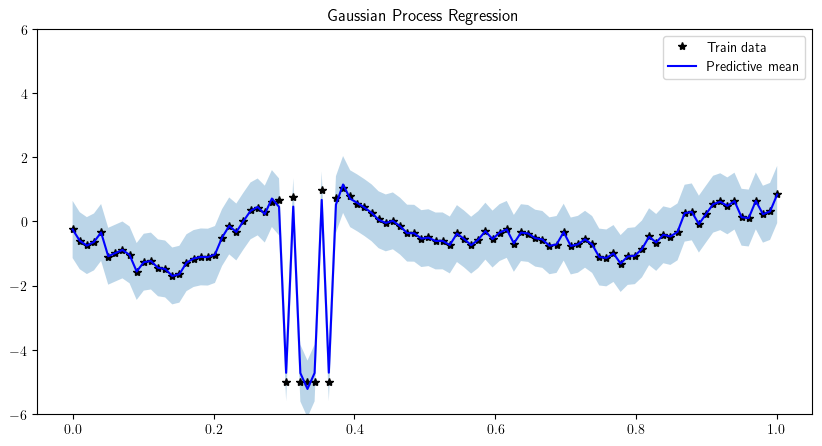

In [ ]:
# Instantiate and train
gp = GPRegressor(mean = 0, length_scale=0.1, rbf_variance = 1, noise = 0.04)
gp.fit(x_train, y_train)

max_loss = -np.inf

for ls in [0.01, 0.1, 1]:
    for rbf_v in [0.1, 1, 5]:
        for noise_l in [0.01, 0.04]:
            loss = gp.loo_cv(ls, rbf_v, noise_l)
            # print(f'ls: {ls}, rbf_v: {rbf_v}, noise: {noise_l} ---- loss={loss}')
            if loss > max_loss:
                max_loss = loss
                best_hp = ls, rbf_v, noise_l

print(max_loss)
print(best_hp)

best_ls, best_rbf_variance, best_noise = best_hp

gp = GPRegressor(mean=0, length_scale=best_ls, rbf_variance=best_rbf_variance, noise=best_noise)
gp.fit(x_train, y_train)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, cov = gp.predict(x_test)
std = np.sqrt(cov)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_train, y_train, 'k*', label='Train data')
plt.plot(x_test, mu.ravel(), 'b', label='Predictive mean')
plt.fill_between(x_test.ravel(), mu.ravel() - 2 * std, mu.ravel() + 2 * std, alpha=0.3)
plt.title("Gaussian Process Regression")
plt.ylim(-6, 6)
plt.legend()
plt.show()

-9.166000556731962
-9.166000532194445
-9.16600054683142
-9.166000558862788
0.6721545574036192
0.6721544971638798
0.6721544186746149
0.6721545646764024
-9.315743612341159
-9.315743591451554
-9.315743605354191
-9.315743615146948
-8.053255785332105
-8.053255879584803
-8.053255789303893
-8.053255776968168
-9.383249725743127
-9.38324973000025
-9.38324971802162
-9.383249726984241
-9.39265958290801
-9.39265958341097
-9.39265958363065
-9.392659584560482
-9.393498690584412
-9.39349869088763
-9.393498690737674
-9.393498692248206
-9.404900330466567
-9.404900329573685
-9.404900325728372
-9.404900332209595
-9.429754630569757
-9.429754627592082
-9.42975461928074
-9.429754632522954
-9.519852278924603
-9.519852267733398
-9.519852251407427
-9.519852281737242
-9.59290674347324
-9.592906690898749
-9.592906679013232
-9.592906748064316
-9.650907689466022
-9.650907662585801
-9.650907642166498
-9.650907693245301
-9.8332587875299
-9.833258765498083
-9.833258722309447
-9.8332587900919
-10.159279827436613
-10.1

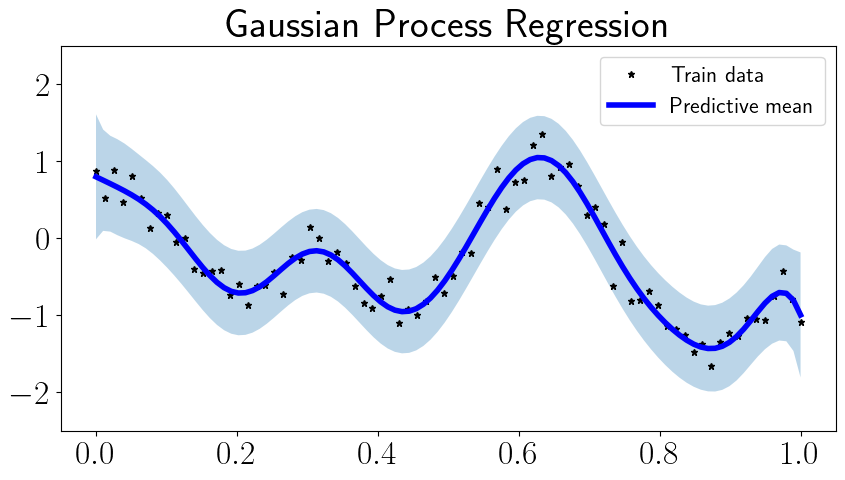

In [4]:
# Instantiate and train
prior_mean = ConstantMean(constant=0)
gp = GPRegressor(mean = prior_mean, length_scale=0.1, rbf_variance = 1, noise = 0.04)
gp.fit(x_train, y_train)

gp.optimize_loo_cv()

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, cov = gp.predict(x_test)
std = np.sqrt(cov)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_train, y_train, 'k*', label='Train data')
plt.plot(x_test, mu.ravel(), 'b', label='Predictive mean')
plt.fill_between(x_test.ravel(), mu.ravel() - 2 * std, mu.ravel() + 2 * std, alpha=0.3)
plt.title("Gaussian Process Regression")
plt.ylim(-2.5, 2.5)
plt.legend()
plt.show()

## RCGP

1.3356993041035847
[0.98320183 0.91055037 0.87283823 0.89860061 0.97169059 0.77023981
 0.80783817 0.82906415 0.79148275 0.64651817 0.72618557 0.7329718
 0.67751417 0.6693161  0.61688229 0.62912738 0.72017989 0.75515463
 0.76986116 0.76810253 0.79062965 0.93631225 0.9948229  0.9711727
 0.99999804 0.9669869  0.95427204 0.97611695 0.91259147 0.89716918
 0.76955756 0.87143077 0.73008588 0.78306783 0.80942177 0.81025686
 0.78671388 0.8781144  0.79020133 0.8627467  0.92736309 0.94541788
 0.98176567 0.99891709 0.99929263 0.99985338 0.9942939  0.96415418
 0.96510892 0.92662734 0.93674668 0.90765055 0.91281486 0.87299449
 0.96404496 0.92426852 0.55538108 0.55538108 0.55538108 0.92356375
 0.96768936 0.55538108 0.55538108 0.96904163 0.96192477 0.93227681
 0.92158283 0.87048588 0.8781957  0.97235293 0.86448643 0.88351052
 0.92263537 0.881292   0.76848119 0.75965021 0.80257533 0.71047744
 0.77547988 0.77996615 0.84010906 0.94381304 0.89525992 0.95632847
 0.94266442 0.97166907 0.98165748 0.97472436 

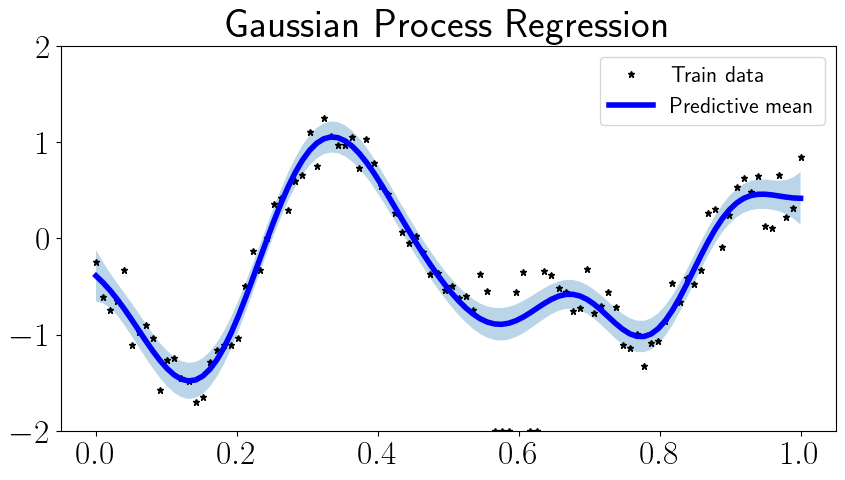

In [5]:
# Instantiate and train
prior_mean = ConstantMean(constant=0)
rcgp = RCGPRegressor(mean = prior_mean, length_scale=0.1, rbf_variance = 1, noise = 0.04, epsilon = 0.1)
rcgp.fit(x_train, y_train)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, std = rcgp.predict(x_test)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_train, y_train, 'k*', label='Train data')
plt.plot(x_test, mu.ravel(), 'b', label='Predictive mean')
plt.fill_between(x_test.ravel(), mu.ravel() - 2 * std, mu.ravel() + 2 * std, alpha=0.3)
plt.title("Gaussian Process Regression")
plt.ylim(-2, 2)
plt.legend()
plt.show()

-54.08560444581555
(0.1, 10, 0.04)


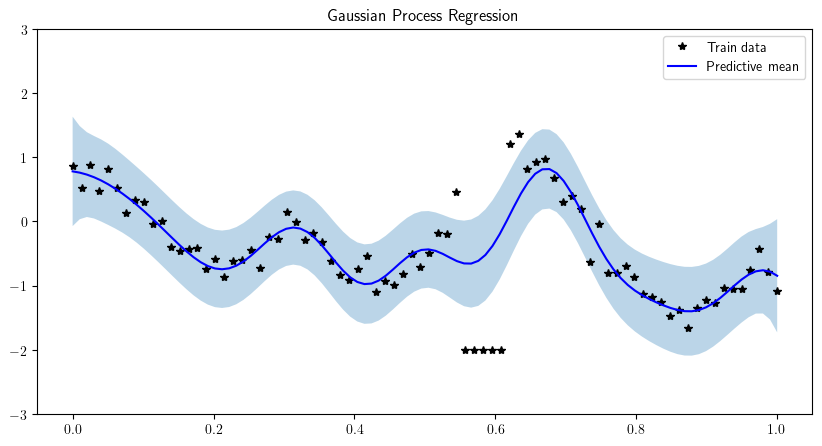

In [ ]:
# Instantiate and train
rcgp = RCGPRegressor(mean = 0, length_scale=0.1, rbf_variance = 1, noise = 0.04, epsilon = 0.05)
rcgp.fit(x_train, y_train)

max_loss = -np.inf

for ls in [0.01, 0.1, 1, 10]:
    for rbf_v in [0.1, 1, 10]:
        for noise_l in [0.01, 0.04, 0.1, 1]:
            loss = rcgp.loo_cv(ls, rbf_v, noise_l)
            # print(f'ls: {ls}, rbf_v: {rbf_v}, noise: {noise_l} ---- loss={loss}')
            if loss > max_loss:
                max_loss = loss
                best_hp = ls, rbf_v, noise_l

print(max_loss)
print(best_hp)

best_ls, best_rbf_variance, best_noise = best_hp

rcgp = RCGPRegressor(mean=0, length_scale=best_ls, rbf_variance=best_rbf_variance, noise=best_noise, epsilon=0.01)
rcgp.fit(x_train, y_train)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, cov = rcgp.predict(x_test)
std = np.sqrt(cov)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_train, y_train, 'k*', label='Train data')
plt.plot(x_test, mu.ravel(), 'b', label='Predictive mean')
plt.fill_between(x_test.ravel(), mu.ravel() - 2 * std, mu.ravel() + 2 * std, alpha=0.3)
plt.title("Gaussian Process Regression")
plt.ylim(-3, 3)
plt.legend()
plt.show()

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
2.6733091621271186
(0.1, 1, 0.04)


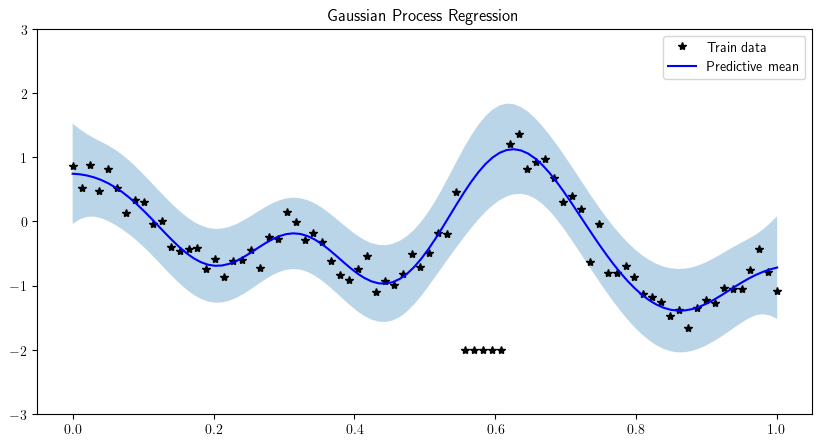

In [ ]:
# Mask to keep all indices that are NOT outliers
mask = np.ones(len(x_train), dtype=bool)
mask[outlier_indices] = False

print(mask)

# Apply the mask to x_train and y_train
x_train_no_outliers = x_train[mask]
y_train_no_outliers = y_train[mask]

# Instantiate and train
rcgp = RCGPRegressor(mean = 0, length_scale=0.1, rbf_variance = 1, noise = 0.04, epsilon = 0.05)
rcgp.fit(x_train_no_outliers, y_train_no_outliers)

max_loss = -np.inf

for ls in [0.01, 0.1, 1]:
    for rbf_v in [0.1, 1, 5]:
        for noise_l in [0.01, 0.04]:
            loss = rcgp.loo_cv(ls, rbf_v, noise_l)
            # print(f'ls: {ls}, rbf_v: {rbf_v}, noise: {noise_l} ---- loss={loss}')
            if loss > max_loss:
                max_loss = loss
                best_hp = ls, rbf_v, noise_l

print(max_loss)
print(best_hp)

best_ls, best_rbf_variance, best_noise = best_hp

rcgp = RCGPRegressor(mean=0, length_scale=best_ls, rbf_variance=best_rbf_variance, noise=best_noise, epsilon=0.01)
rcgp.fit(x_train_no_outliers, y_train_no_outliers)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, cov = rcgp.predict(x_test)
std = np.sqrt(cov)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_train, y_train, 'k*', label='Train data')
plt.plot(x_test, mu.ravel(), 'b', label='Predictive mean')
plt.fill_between(x_test.ravel(), mu.ravel() - 2 * std, mu.ravel() + 2 * std, alpha=0.3)
plt.title("Gaussian Process Regression")
plt.ylim(-3, 3)
plt.legend()
plt.show()

## Sine function

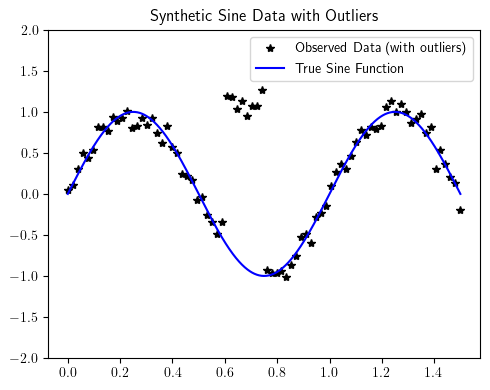

In [ ]:
np.random.seed(42)

# Parameters
amplitude = 1
frequency = 2 * np.pi
noise_variance = 0.01

# Input points
x_train = np.linspace(0, 1.5, 80).reshape(-1, 1)

# True sine mean
mean_y = amplitude * np.sin(frequency * x_train)

# Add Gaussian noise
y_train = mean_y + np.random.normal(0, np.sqrt(noise_variance), size=mean_y.shape)

prior_mean = 0.25 * np.sin(2 * np.pi * x_train)
prior_mean_test = 0.25 * np.sin(2 * np.pi * x_test)

# Add outliers
outlier_range = np.where((x_train >= 0.6) & (x_train <= 0.75))[0]
outlier_indices = np.random.choice(outlier_range, 8, replace=False)
outlier_values = np.random.normal(loc=1.1, scale=0.1, size=outlier_indices.shape[0])
y_train[outlier_indices] = outlier_values.reshape(-1,1)

# Mask to keep all indices that are NOT outliers
mask = np.ones(len(x_train), dtype=bool)
mask[outlier_indices] = False

# Apply the mask to x_train and y_train
x_train_no_outliers = x_train[mask]
y_train_no_outliers = y_train[mask]
prior_mean_no_outliers = prior_mean[mask]

# Test points
x_test = np.linspace(0, 1.5, 1000).reshape(-1, 1)
mean_y_test = amplitude * np.sin(frequency * x_test)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(x_train, y_train, 'k*', label='Observed Data (with outliers)')
plt.plot(x_test, mean_y_test, 'b-', label='True Sine Function')
plt.ylim([-2, 2])
plt.title("Synthetic Sine Data with Outliers")
plt.legend()
plt.tight_layout()
plt.show()

-3.2418358851669575
(0.1, 1, 0.05)


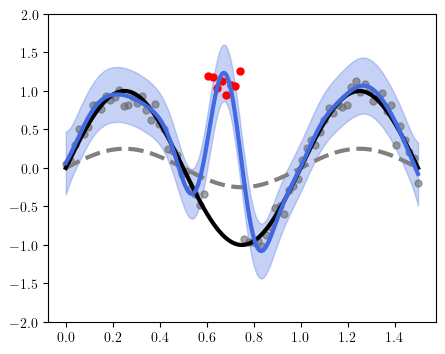

In [ ]:
# Instantiate and train
rcgp = RCGPRegressor(mean = prior_mean, length_scale=0.1, rbf_variance = 1, noise = 0.04, epsilon = 0.05)
rcgp.fit(x_train, y_train)

max_loss = -np.inf

for ls in [0.01, 0.05, 0.1, 0.05, 1]:
    for rbf_v in [0.01, 0.05, 0.1, 0.5, 1]:
        for noise_l in [0.005, 0.01, 0.05]:
            loss = rcgp.loo_cv(ls, rbf_v, noise_l)
            # print(f'ls: {ls}, rbf_v: {rbf_v}, noise: {noise_l} ---- loss={loss}')
            if loss > max_loss:
                max_loss = loss
                best_hp = ls, rbf_v, noise_l

print(max_loss)
print(best_hp)

best_ls, best_rbf_variance, best_noise = best_hp

rcgp = RCGPRegressor(mean=0, length_scale=best_ls, rbf_variance=best_rbf_variance, noise=best_noise, epsilon=0.10)
rcgp.fit(x_train, y_train)

# # Predict on test points
# x_test = np.linspace(0, 1.5, 100).reshape(-1, 1)
mu, cov = rcgp.predict(x_test)
std = np.sqrt(cov)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(x_train[mask], y_train[mask], 'o', color='dimgray', markersize=5, alpha=0.6)  # darker grey, slightly transparent
plt.plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=5)               # red dots

# plt.plot(x_test, prior_mean_test, '--', color='grey', linewidth=3)                     # thicker grey dashed prior mean
plt.plot(x_test, mean_y_test, color='black', linewidth=3)                              # thicker true function
plt.plot(x_test, mu.ravel(), color="royalblue", linewidth=3)                             # thicker lighter blue predictive mean

plt.fill_between(x_test.ravel(), 
                 mu.ravel() - 1 * std, 
                 mu.ravel() + 1 * std, 
                 alpha=0.3, color='royalblue')                                           # lighter blue uncertainty band

plt.ylim(-2, 2)
plt.show()


In [ ]:
epsilon = 0.1

# Instantiate and train
rcgp = RCGPRegressor(mean = prior_mean_no_outliers, length_scale=0.1, rbf_variance = 1, noise = 0.04, epsilon = epsilon)
rcgp.fit(x_train_no_outliers, y_train_no_outliers)

max_loss = -np.inf

for ls in [0.01, 0.05, 0.1, 0.05, 1]:
    for rbf_v in [0.01, 0.05, 0.1, 0.5, 1]:
        for noise_l in [0.005, 0.01, 0.05]:
            loss = rcgp.loo_cv(ls, rbf_v, noise_l)
            # print(f'ls: {ls}, rbf_v: {rbf_v}, noise: {noise_l} ---- loss={loss}')
            if loss > max_loss:
                max_loss = loss
                best_hp = ls, rbf_v, noise_l

print(max_loss)
print(best_hp)

best_ls, best_rbf_variance, best_noise = best_hp

rcgp = RCGPRegressor(mean=prior_mean, length_scale=best_ls, rbf_variance=best_rbf_variance, noise=best_noise, epsilon=epsilon)
rcgp.fit(x_train_no_outliers, y_train_no_outliers)

# Predict on test points
mu, cov = rcgp.predict(x_test)
std = np.sqrt(cov)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(x_train[mask], y_train[mask], 'o', color='dimgray', markersize=5, alpha=0.6)  # darker grey, slightly transparent
plt.plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=5)               # red dots

# plt.plot(x_test, prior_mean_test, '--', color='grey', linewidth=3)                     # thicker grey dashed prior mean
plt.plot(x_test, mean_y_test, color='black', linewidth=3)                              # thicker true function
plt.plot(x_test, mu.ravel(), color="royalblue", linewidth=3)                             # thicker lighter blue predictive mean

plt.fill_between(x_test.ravel(), 
                 mu.ravel() - 1 * std, 
                 mu.ravel() + 1 * std, 
                 alpha=0.3, color='royalblue')                                           # lighter blue uncertainty band

plt.ylim(-2, 2)
plt.show()

17.595985572129095
(0.1, 0.05, 0.05)


ValueError: operands could not be broadcast together with shapes (72,1) (80,1) 

In [ ]:
epsilon = 0.1

# Instantiate and train
rcgp = RCGPRegressor(mean = prior_mean_no_outliers, length_scale=0.1, rbf_variance = 1, noise = 0.04, epsilon = epsilon)
rcgp.fit(x_train_no_outliers, y_train_no_outliers)

max_loss = -np.inf

for ls in [0.01, 0.05, 0.1, 0.05, 1]:
    for rbf_v in [0.01, 0.05, 0.1, 0.5, 1]:
        for noise_l in [0.005, 0.01, 0.05]:
            loss = rcgp.loo_cv(ls, rbf_v, noise_l)
            # print(f'ls: {ls}, rbf_v: {rbf_v}, noise: {noise_l} ---- loss={loss}')
            if loss > max_loss:
                max_loss = loss
                best_hp = ls, rbf_v, noise_l

print(max_loss)
print(best_hp)

best_ls, best_rbf_variance, best_noise = best_hp

rcgp = RCGPRegressor(mean=prior_mean, length_scale=best_ls, rbf_variance=best_rbf_variance, noise=best_noise, epsilon=epsilon)
rcgp.fit(x_train_no_outliers, y_train_no_outliers)

# Predict on test points
mu, cov = rcgp.predict(x_test)
std = np.sqrt(cov)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(x_train[mask], y_train[mask], 'o', color='dimgray', markersize=5, alpha=0.6)  # darker grey, slightly transparent
plt.plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=5)               # red dots

# plt.plot(x_test, prior_mean_test, '--', color='grey', linewidth=3)                     # thicker grey dashed prior mean
plt.plot(x_test, mean_y_test, color='black', linewidth=3)                              # thicker true function
plt.plot(x_test, mu.ravel(), color="royalblue", linewidth=3)                             # thicker lighter blue predictive mean

plt.fill_between(x_test.ravel(), 
                 mu.ravel() - 1 * std, 
                 mu.ravel() + 1 * std, 
                 alpha=0.3, color='royalblue')                                           # lighter blue uncertainty band

plt.ylim(-2, 2)
plt.show()

17.595985572129095
(0.1, 0.05, 0.05)


ValueError: operands could not be broadcast together with shapes (72,1) (80,1) 

## Plot

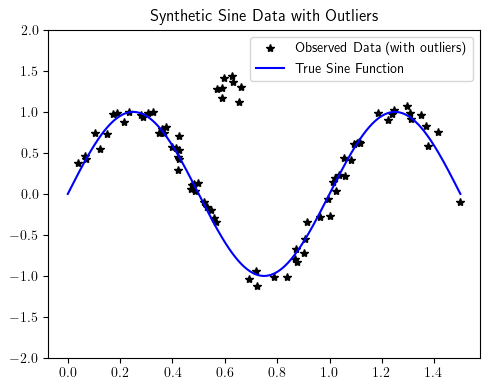

In [89]:
np.random.seed(41)

# Parameters
amplitude = 1
frequency = 2 * np.pi
noise_variance = 0.01

# Input points
x_train = np.random.uniform(0, 1.5, 80).reshape(-1, 1)

# True sine mean
mean_y = amplitude * np.sin(frequency * x_train)

# Add Gaussian noise
y_train = mean_y + np.random.normal(0, np.sqrt(noise_variance), size=mean_y.shape)

# Add outliers
outlier_range = np.where((x_train >= 0.57) & (x_train <= 0.67))[0]
outlier_indices = np.random.choice(outlier_range, 8, replace=False)
outlier_values = np.random.normal(loc=1.3, scale=0.2, size=outlier_indices.shape[0])
y_train[outlier_indices] = outlier_values.reshape(-1,1)


# Test points
x_test = np.linspace(0, 1.5, 1000).reshape(-1, 1)
mean_y_test = amplitude * np.sin(frequency * x_test)

prior_mean = 0.5 * np.sin(2 * np.pi * x_train)
prior_mean_test = 0.5 * np.sin(2 * np.pi * x_test)

# Mask to keep all indices that are NOT outliers
mask = np.ones(len(x_train), dtype=bool)
mask[outlier_indices] = False

# Apply the mask to x_train and y_train
x_train_no_outliers = x_train[mask]
y_train_no_outliers = y_train[mask]
prior_mean_no_outliers = prior_mean[mask]

# Plot
plt.figure(figsize=(5, 4))
plt.plot(x_train, y_train, 'k*', label='Observed Data (with outliers)')
plt.plot(x_test, mean_y_test, 'b-', label='True Sine Function')
plt.ylim([-2, 2])
plt.title("Synthetic Sine Data with Outliers")
plt.legend()
plt.tight_layout()
plt.show()

17.745865280857473
(0.1, 0.05, 0.05)


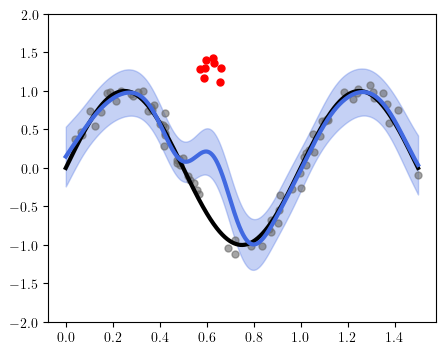

In [90]:
epsilon = 0.1

# Instantiate and train
mean_function = SineMean(amplitude=0.5, frequency=2*np.pi)
rcgp = RCGPRegressor(mean = mean_function, length_scale=0.1, rbf_variance = 1, noise = 0.04, epsilon = epsilon)
rcgp.fit(x_train_no_outliers, y_train_no_outliers)

max_loss = -np.inf

for ls in [0.01, 0.05, 0.1, 0.05, 1]:
    for rbf_v in [0.01, 0.05, 0.1, 0.5, 1]:
        for noise_l in [0.005, 0.01, 0.05]:
            loss = rcgp.loo_cv(ls, rbf_v, noise_l)
            # print(f'ls: {ls}, rbf_v: {rbf_v}, noise: {noise_l} ---- loss={loss}')
            if loss > max_loss:
                max_loss = loss
                best_hp = ls, rbf_v, noise_l

print(max_loss)
print(best_hp)

best_ls, best_rbf_variance, best_noise = best_hp

rcgp = RCGPRegressor(mean=mean_function, length_scale=best_ls, rbf_variance=best_rbf_variance, noise=best_noise, epsilon=epsilon)
rcgp.fit(x_train, y_train)

# Predict on test points
mu, cov = rcgp.predict(x_test)
std = np.sqrt(cov)
prior_mean_test = mean_function(x_test)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(x_train[mask], y_train[mask], 'o', color='dimgray', markersize=5, alpha=0.6)  # darker grey, slightly transparent
plt.plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=5)               # red dots

# plt.plot(x_test, prior_mean_test, '--', color='grey', linewidth=3)                     # thicker grey dashed prior mean
plt.plot(x_test, mean_y_test, color='black', linewidth=3)                              # thicker true function
plt.plot(x_test, mu.ravel(), color="royalblue", linewidth=3)                             # thicker lighter blue predictive mean

plt.fill_between(x_test.ravel(), 
                 mu.ravel() - 1 * std, 
                 mu.ravel() + 1 * std, 
                 alpha=0.3, color='royalblue')                                           # lighter blue uncertainty band

plt.ylim(-2, 2)
plt.show()

16.9545873641812
(0.1, 0.05, 0.01)


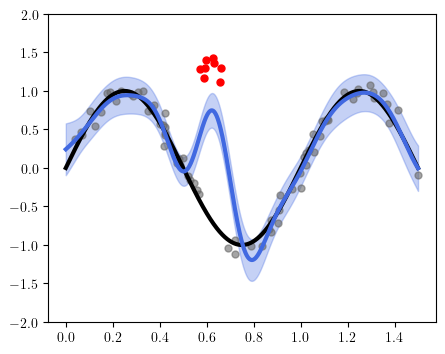

In [91]:
epsilon = 0.1

# Instantiate and train
mean_function = ConstantMean(constant=0.0)
rcgp = RCGPRegressor(mean = mean_function, length_scale=0.1, rbf_variance = 1, noise = 0.04, epsilon = epsilon)
rcgp.fit(x_train_no_outliers, y_train_no_outliers)

max_loss = -np.inf

for ls in [0.01, 0.05, 0.1, 0.05, 1]:
    for rbf_v in [0.01, 0.05, 0.1, 0.5, 1]:
        for noise_l in [0.005, 0.01, 0.05]:
            loss = rcgp.loo_cv(ls, rbf_v, noise_l)
            # print(f'ls: {ls}, rbf_v: {rbf_v}, noise: {noise_l} ---- loss={loss}')
            if loss > max_loss:
                max_loss = loss
                best_hp = ls, rbf_v, noise_l

print(max_loss)
print(best_hp)

best_ls, best_rbf_variance, best_noise = best_hp

rcgp = RCGPRegressor(mean=mean_function, length_scale=best_ls, rbf_variance=best_rbf_variance, noise=best_noise, epsilon=epsilon)
rcgp.fit(x_train, y_train)

# Predict on test points
mu, cov = rcgp.predict(x_test)
std = np.sqrt(cov)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(x_train[mask], y_train[mask], 'o', color='dimgray', markersize=5, alpha=0.6)  # darker grey, slightly transparent
plt.plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=5)               # red dots

# plt.plot(x_test, prior_mean_test, '--', color='grey', linewidth=3)                     # thicker grey dashed prior mean
plt.plot(x_test, mean_y_test, color='black', linewidth=3)                              # thicker true function
plt.plot(x_test, mu.ravel(), color="royalblue", linewidth=3)                             # thicker lighter blue predictive mean

plt.fill_between(x_test.ravel(), 
                 mu.ravel() - 1 * std, 
                 mu.ravel() + 1 * std, 
                 alpha=0.3, color='royalblue')                                           # lighter blue uncertainty band

plt.ylim(-2, 2)
plt.show()

43.78330887745666
(0.1, 0.01, 0.01)


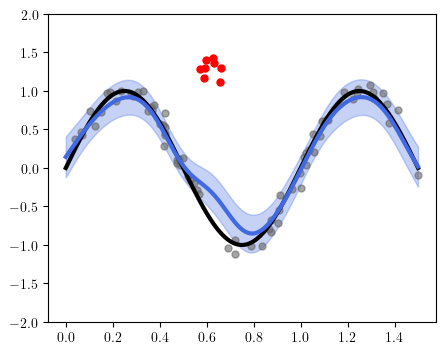

In [92]:
epsilon = 0.6

# Instantiate and train
mean_function = SineMean(amplitude=0.5, frequency=2*np.pi)
rcgp = RCGPRegressor(mean = mean_function, length_scale=0.1, rbf_variance = 1, noise = 0.04, epsilon = epsilon)
rcgp.fit(x_train_no_outliers, y_train_no_outliers)

max_loss = -np.inf

for ls in [0.01, 0.05, 0.1, 0.05, 1]:
    for rbf_v in [0.01, 0.05, 0.1, 0.5, 1]:
        for noise_l in [0.005, 0.01, 0.05]:
            loss = rcgp.loo_cv(ls, rbf_v, noise_l)
            # print(f'ls: {ls}, rbf_v: {rbf_v}, noise: {noise_l} ---- loss={loss}')
            if loss > max_loss:
                max_loss = loss
                best_hp = ls, rbf_v, noise_l

print(max_loss)
print(best_hp)

best_ls, best_rbf_variance, best_noise = best_hp

rcgp = RCGPRegressor(mean=mean_function, length_scale=best_ls, rbf_variance=best_rbf_variance, noise=best_noise, epsilon=epsilon)
rcgp.fit(x_train, y_train)

# Predict on test points
mu, cov = rcgp.predict(x_test)
std = np.sqrt(cov)
prior_mean_test = mean_function(x_test)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(x_train[mask], y_train[mask], 'o', color='dimgray', markersize=5, alpha=0.6)  # darker grey, slightly transparent
plt.plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=5)               # red dots

# plt.plot(x_test, prior_mean_test, '--', color='grey', linewidth=3)                     # thicker grey dashed prior mean
plt.plot(x_test, mean_y_test, color='black', linewidth=3)                              # thicker true function
plt.plot(x_test, mu.ravel(), color="royalblue", linewidth=3)                             # thicker lighter blue predictive mean

plt.fill_between(x_test.ravel(), 
                 mu.ravel() - 1 * std, 
                 mu.ravel() + 1 * std, 
                 alpha=0.3, color='royalblue')                                           # lighter blue uncertainty band

plt.ylim(-2, 2)
plt.show()

-6.115354418427279
(0.05, 0.5, 0.05)


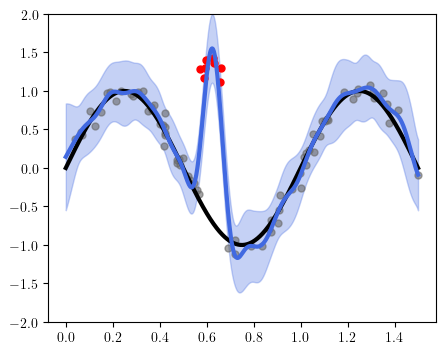

In [93]:
epsilon = 0.1

# Instantiate and train
mean_function = SineMean(amplitude=0.5, frequency=2*np.pi)
rcgp = RCGPRegressor(mean = mean_function, length_scale=0.1, rbf_variance = 1, noise = 0.04, epsilon = epsilon)
rcgp.fit(x_train, y_train)

max_loss = -np.inf

for ls in [0.01, 0.05, 0.1, 0.05, 1]:
    for rbf_v in [0.01, 0.05, 0.1, 0.5, 1]:
        for noise_l in [0.005, 0.01, 0.05]:
            loss = rcgp.loo_cv(ls, rbf_v, noise_l)
            # print(f'ls: {ls}, rbf_v: {rbf_v}, noise: {noise_l} ---- loss={loss}')
            if loss > max_loss:
                max_loss = loss
                best_hp = ls, rbf_v, noise_l

print(max_loss)
print(best_hp)

best_ls, best_rbf_variance, best_noise = best_hp

rcgp = RCGPRegressor(mean=mean_function, length_scale=best_ls, rbf_variance=best_rbf_variance, noise=best_noise, epsilon=epsilon)
rcgp.fit(x_train, y_train)

# Predict on test points
mu, cov = rcgp.predict(x_test)
std = np.sqrt(cov)
prior_mean_test = mean_function(x_test)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(x_train[mask], y_train[mask], 'o', color='dimgray', markersize=5, alpha=0.6)  # darker grey, slightly transparent
plt.plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=5)               # red dots

# plt.plot(x_test, prior_mean_test, '--', color='grey', linewidth=3)                     # thicker grey dashed prior mean
plt.plot(x_test, mean_y_test, color='black', linewidth=3)                              # thicker true function
plt.plot(x_test, mu.ravel(), color="royalblue", linewidth=3)                             # thicker lighter blue predictive mean

plt.fill_between(x_test.ravel(), 
                 mu.ravel() - 1 * std, 
                 mu.ravel() + 1 * std, 
                 alpha=0.3, color='royalblue')                                           # lighter blue uncertainty band

plt.ylim(-2, 2)
plt.show()

## Final plot

In [2]:
def tune_hyperparameters(model):
    max_loss = -np.inf
    for ls in [0.01, 0.05, 0.1, 0.05, 1]:
        for rbf_v in [0.01, 0.05, 0.1, 0.5, 1]:
            for noise_l in [0.005, 0.01, 0.05]:
                loss = model.loo_cv(ls, rbf_v, noise_l)
                # print(f'ls: {ls}, rbf_v: {rbf_v}, noise: {noise_l} ---- loss={loss}')
                if loss > max_loss:
                    max_loss = loss
                    best_ls, best_rbf_variance, best_noise = ls, rbf_v, noise_l
    return best_ls, best_rbf_variance, best_noise

In [ ]:
np.random.seed(41)

# Simulation
x_train = np.sort(np.random.uniform(0, 1.5, 80)).reshape(-1, 1)
mean_y = np.sin(2 * np.pi * x_train)
y_train = mean_y + np.random.normal(0, np.sqrt(0.01), size=mean_y.shape)

# Add outliers
outlier_range = np.where((x_train >= 0.58) & (x_train <= 0.70))[0]
outlier_indices = np.sort(np.random.choice(outlier_range, 8, replace=False))
outlier_values = np.random.normal(loc=1.1, scale=0.2, size=outlier_indices.shape[0])
y_train[outlier_indices] = outlier_values.reshape(-1,1)

print(outlier_indices)

# Test points
x_test = np.linspace(0, 1.5, 1000).reshape(-1, 1)
mean_y_test = np.sin(2 * np.pi * x_test)

# Mask to keep all indices that are NOT outliers
mask = np.ones(len(x_train), dtype=bool)
mask[outlier_indices] = False
x_train_no_outliers = x_train[mask]
y_train_no_outliers = y_train[mask]

# Mean functions
sine_mean = SineMean(amplitude=0.5, frequency=2*np.pi)
constant_mean = ConstantMean(constant=0.0)

# Create a single row with 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(19, 4))  # adjust figsize as needed

initial_length_scale = 0.21
initial_rbf_variance = 1
initial_noise = 0.05

# ---------------- Plot 1: RCGP --------------------
epsilon = 0.1

rcgp = RCGPRegressor(mean = sine_mean, length_scale=initial_length_scale, rbf_variance = initial_rbf_variance, noise = initial_noise, epsilon = epsilon)
rcgp.fit(x_train_no_outliers, y_train_no_outliers)

rcgp.optimize_loo_cv()

rcgp.fit(x_train, y_train)
mu, std = rcgp.predict(x_test)
sine_mean_test = sine_mean(x_test)

ax = axs[0]
axs[0].plot(x_train[mask], y_train[mask], 'o', color='dimgray', alpha=0.6)
axs[0].plot(x_train[~mask], y_train[~mask], 'o', color='red')
axs[0].plot(x_test, sine_mean_test, '--', color='grey')
axs[0].plot(x_test, mean_y_test, color='black')
axs[0].plot(x_test, mu.ravel(), color="royalblue")
axs[0].fill_between(x_test.ravel(), mu.ravel() - 2 * std, mu.ravel() + 2 * std, alpha=0.3, color='royalblue')

# ---------------- Plot 2: Poor prior specification --------------------
epsilon = 0.1
rcgp = RCGPRegressor(mean = constant_mean, length_scale=initial_length_scale, rbf_variance = initial_rbf_variance, noise = initial_noise, epsilon = epsilon)
rcgp.fit(x_train_no_outliers, y_train_no_outliers)

rcgp.optimize_loo_cv()

rcgp.fit(x_train, y_train)
mu, std = rcgp.predict(x_test)
constant_mean_test = constant_mean(x_test)

ax = axs[1]
axs[1].plot(x_train[mask], y_train[mask], 'o', color='dimgray', alpha=0.6)
axs[1].plot(x_train[~mask], y_train[~mask], 'o', color='red')
axs[1].plot(x_test, constant_mean_test, '-', color='grey')
axs[1].plot(x_test, mean_y_test, color='black')
axs[1].plot(x_test, mu.ravel(), color="green")
axs[1].fill_between(x_test.ravel(), mu.ravel() - 2 * std, mu.ravel() + 2 * std, alpha=0.3, color='green')

# ---------------- Plot 3: Poor specification of c --------------------
epsilon = 0.8
rcgp = RCGPRegressor(mean = sine_mean, length_scale=initial_length_scale, rbf_variance = initial_rbf_variance, noise = initial_noise, epsilon = epsilon)
rcgp.fit(x_train_no_outliers, y_train_no_outliers)

rcgp.optimize_loo_cv()

rcgp.fit(x_train, y_train)
mu, std = rcgp.predict(x_test)

ax = axs[2]
axs[2].plot(x_train[mask], y_train[mask], 'o', color='dimgray', alpha=0.6)
axs[2].plot(x_train[~mask], y_train[~mask], 'o', color='red')
axs[2].plot(x_test, mean_y_test, color='black')
axs[2].plot(x_test, mu.ravel(), color="orange")
axs[2].fill_between(x_test.ravel(), mu.ravel() - 2 * std, mu.ravel() + 2 * std, alpha=0.3, color='orange')

# ---------------- Plot 4: Non-robust hyperparameter optimisation --------------------
epsilon = 0.1

rcgp = RCGPRegressor(mean = sine_mean, length_scale=initial_length_scale, rbf_variance = initial_rbf_variance, noise = initial_noise, epsilon = epsilon)
rcgp.fit(x_train, y_train)

rcgp.optimize_loo_cv()

mu, std = rcgp.predict(x_test)

ax = axs[3]
axs[3].plot(x_train[mask], y_train[mask], 'o', color='dimgray', alpha=0.6)
axs[3].plot(x_train[~mask], y_train[~mask], 'o', color='red')
axs[3].plot(x_test, mean_y_test, color='black')
axs[3].plot(x_test, mu.ravel(), color="teal")
axs[3].fill_between(x_test.ravel(), mu.ravel() - 2 * std, mu.ravel() + 2 * std, alpha=0.3, color='teal')

# Set common limits and ticks
for ax in axs:
    ax.set_ylim(-1.7, 1.7)
    ax.set_xticks([0, 0.5, 1, 1.5])
    ax.set_xlabel(r'$x$')

# Customize the y-axis of the first plot
axs[0].set_yticks([-1.0, 0, 1.0])
axs[0].set_ylabel(r'$y$')
for ax in axs[1:]:
    ax.tick_params(labelleft=False)

handles = [
    axs[0].plot([], [], '--', color='grey', label=r'$m_1(x) = \frac{1}{2}\sin(2\pi x)$ (good prior mean)')[0],
    axs[0].plot([], [], '-', color='grey', label=r'$m_2(x) = 0$ (bad prior mean)')[0],
    # axs[0].plot([], [], color='black', label='True function')[0],
    axs[0].plot([], [], color='royalblue', label=r'RCGP $(m_1, c= Q_{N}(1 - \epsilon))$')[0],
    axs[1].plot([], [], color='green', label=r'RCGP $(m_2, c= Q_{N}(1 - \epsilon))$')[0],
    axs[2].plot([], [], color='orange', label=r'RCGP $(m_1, c= 0.2)$')[0],
    axs[3].plot([], [], color='teal', label=r'RCGP$^\ast$ $(m_1, c= Q_{N}(1 - \epsilon))$')[0]
]

labels = [h.get_label() for h in handles]

# Add a figure-level legend below the subplots, larger font and no border
fig.legend(
    handles, 
    labels, 
    loc='lower center', 
    ncol=3, 
    bbox_to_anchor=(0.505, -0.17),  # Adjust vertical position
    prop={'size': 24},  # Large font
    frameon=False  # Remove legend border
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.35)  # Make more room for the bigger legend
plt.show()


[36 37 38 39 40 41 42 43]
0.5125636305559991
Optimized length_scale: 0.4361, noise: 0.018569, rbf_variance: 0.5494
0.5125636305559991
0.7927623335745371
0.989608189985973
Optimized length_scale: 0.4559, noise: 0.018192, rbf_variance: 80.4034
0.989608189985973
1.0823239002431058
0.1590990406424987
Optimized length_scale: 0.4413, noise: 0.010901, rbf_variance: 124.5327
0.1590990406424987
0.1797704529581412
0.7927623335745371
Optimized length_scale: 0.0299, noise: 0.021918, rbf_variance: 0.2502
0.7927623335745371


0.5125636305559991
Optimized length_scale: 0.4386, noise: 0.008394, rbf_variance: 0.9786
0.5125636305559991
0.7927623335745371
0.4573964905239983
Optimized length_scale: 0.4399, noise: 0.008135, rbf_variance: 0.9567
0.4573964905239983
0.5089113499218902
0.4161858509855486
Optimized length_scale: 0.4415, noise: 0.007905, rbf_variance: 0.9462
0.4161858509855486
0.4535561024021979
0.3685875163193027
Optimized length_scale: 0.4373, noise: 0.007376, rbf_variance: 133.3339
0.3685875163193027
0.4098916968819449
0.29836042860331324
Optimized length_scale: 0.4213, noise: 0.006768, rbf_variance: 83.2994
0.29836042860331324
0.33739761043176963
0.2559518724016153
Optimized length_scale: 0.4196, noise: 0.006316, rbf_variance: 81.0078
0.2559518724016153
0.2623105804484302
0.22887550545402502
Optimized length_scale: 0.4140, noise: 0.005983, rbf_variance: 62.0030
0.22887550545402502
0.23912505252981803
0.1590990406424987
Optimized length_scale: 0.4251, noise: 0.004928, rbf_variance: 74.0012
0.15909904

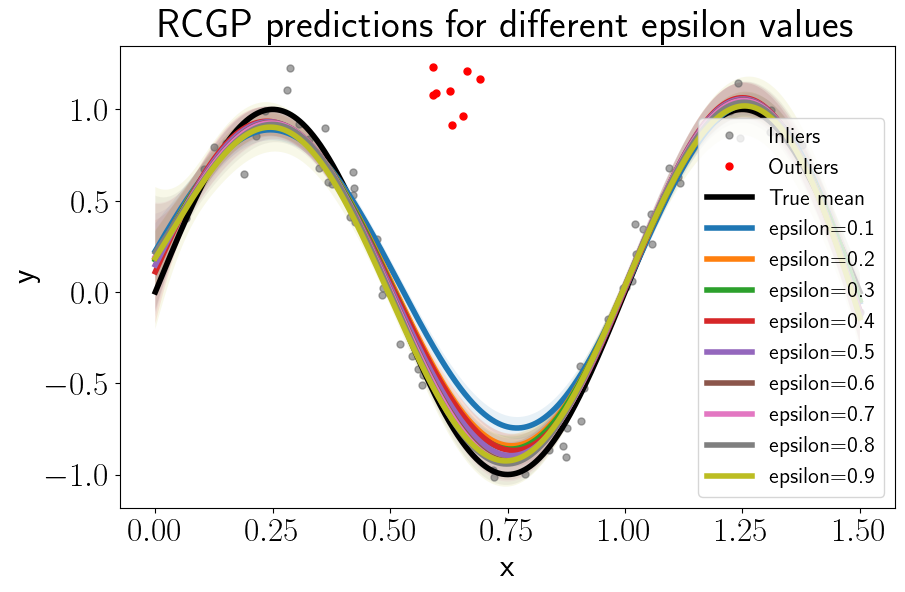

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these are already defined:
# x_train, y_train, x_train_no_outliers, y_train_no_outliers
# x_test, mean_y_test
# mask
# sine_mean, initial_length_scale, initial_rbf_variance, initial_noise

fig, axs = plt.subplots(1, 1, figsize=(10, 6))  # Single axis for overlay plot
ax = axs

# Plot the data points once
ax.plot(x_train[mask], y_train[mask], 'o', color='dimgray', alpha=0.6, label='Inliers')
ax.plot(x_train[~mask], y_train[~mask], 'o', color='red', label='Outliers')
ax.plot(x_test, mean_y_test, color='black', label='True mean')

# Loop over epsilon values
for epsilon in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    rcgp = RCGPRegressor(mean=sine_mean, length_scale=0.3,
                         rbf_variance=0.4, noise=0.01,
                         epsilon=epsilon)

    rcgp.fit(x_train_no_outliers, y_train_no_outliers)
    rcgp.optimize_loo_cv()
    rcgp.fit(x_train, y_train)

    mu, std = rcgp.predict(x_test)

    ax.plot(x_test, mu.ravel(), label=f'epsilon={epsilon:.1f}')
    ax.fill_between(x_test.ravel(), 
                    mu.ravel() - 2 * std, 
                    mu.ravel() + 2 * std, 
                    alpha=0.1)

ax.legend()
ax.set_title("RCGP predictions for different epsilon values")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()


## Test

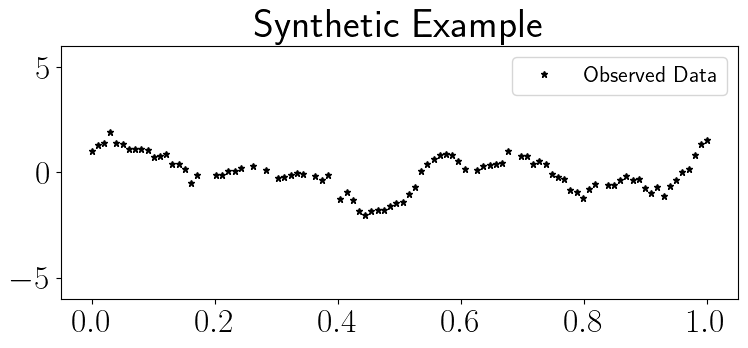

In [13]:
np.random.seed(42)

# Initialisation
constant_mean = 0
length_scale = 0.05
variance = 1.0
noise_variance = 0.04

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=variance)

x_train = np.linspace(0, 1, 100).reshape(-1, 1)
K_train = rbf_kernel(x_train, x_train)
K_train_noise = K_train + noise_variance * np.eye(len(x_train))
y_train = np.random.multivariate_normal(mean_func(x_train).flatten(), K_train_noise).reshape(-1, 1)

# Add outliers
indices_025 = np.where((x_train >= 0.05) & (x_train <= 0.95))[0]
outlier_indices_025 = np.random.choice(indices_025, 10, replace=False)
y_train[outlier_indices_025] = -10

# indices_075 = np.where((x_train >= 0.70) & (x_train <= 0.80))[0]
# outlier_indices_025 = np.random.choice(indices_075, 9, replace=False)
# y_train[outlier_indices_025] = 5

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.plot(x_train, y_train, 'k*', label='Observed Data')
axs.set_title("Synthetic Example")
axs.set_ylim([-6, 6])
axs.legend()

plt.tight_layout()
plt.show()

2.806855548737317


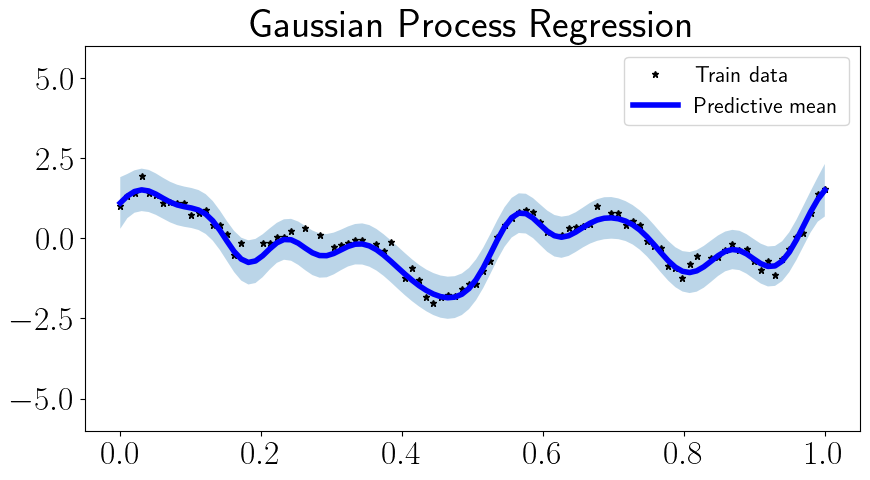

In [15]:
# Instantiate and train
rcgp = RCGPRegressor(mean = mean_func, length_scale=0.05, rbf_variance = 1, noise = 0.04, epsilon = 0.1)
rcgp.fit(x_train, y_train)

# # Optimize hyperparameters
# rcgp.optimize_hyperparameters()

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, cov = rcgp.predict(x_test)
std = np.sqrt(cov)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_train, y_train, 'k*', label='Train data')
plt.plot(x_test, mu.ravel(), 'b', label='Predictive mean')
plt.fill_between(x_test.ravel(), mu.ravel() - 2 * std, mu.ravel() + 2 * std, alpha=0.3)
plt.title("Gaussian Process Regression")
plt.ylim(-6, 6)
plt.legend()
plt.show()